# Model Comparison: Lead Price 7-Day Return Prediction (6 Features - Scheme 2)

This notebook compares the performance of all regression models on predicting 7-day returns of lead prices using 6 features (Scheme 2).

## Features Used (6 Features):
1. returns
2. MA30
3. rolling_volatility
4. MACD30
5. MACD15
6. RSI

## Models Included:
1. Linear Regression
2. Ridge Regression
3. Random Forest
4. XGBoost
5. LSTM
6. Transformer
7. ARIMA
8. SARIMA


In [111]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os
import warnings
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Add project root to Python path
try:
    current_dir = Path.cwd()
    if current_dir.name == 'notebooks':
        project_root = current_dir.parent
    else:
        project_root = current_dir
except:
    project_root = Path(r'C:\Project_Macro_Impact_On_Lead')

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

os.chdir(project_root)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Import data splitting function
from src.data.train_test_split_walk_forward import train_test_split_time_series

# Import all regression models
from src.regression.reg_baseline_linear import train_linear_regression, train_ridge_regression
from src.regression.reg_tree_models import train_random_forest, train_xgboost
from src.regression.reg_lstm import train_lstm
from src.regression.reg_transformer import train_transformer
from src.regression.reg_time_series import train_arima, train_sarima

print("All imports successful")


All imports successful


In [112]:
# Load data - using lopbdy_features.csv which contains pure price features (no macro factors)
df = pd.read_csv("data_processed/lopbdy_features.csv", index_col=0, parse_dates=True)

print(f"Data shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()


Data shape: (6275, 17)
Columns: ['LOPBDY LME Comdty', 'returns', 'MA7', 'MA30', 'rolling_volatility', 'EMA5', 'EMA15', 'EMA30', 'MACD5', 'MACD15', 'MACD30', 'RSI', 'BB_upper', 'BB_middle', 'BB_lower', 'return_7d', 'target']


,LOPBDY LME Comdty,returns,MA7,MA30,rolling_volatility,EMA5,EMA15,EMA30,MACD5,MACD15,MACD30,RSI,BB_upper,BB_middle,BB_lower,return_7d,target
Security,,,,,,,,,,,,,,,,,
2025-10-24,1979.0,-0.004026,1989.000000,1993.266667,0.007584,1986.095324,1996.292291,1993.244578,-8.558650,1.638318,-1.409395,26.126126,2064.601068,2011.175,1957.748932,-0.013896,0
2025-10-23,1973.0,-0.003032,1985.857143,1993.633333,0.007477,1981.730216,1993.380755,1991.938477,-11.319760,0.330779,-1.111499,27.531646,2065.739353,2010.175,1954.610647,-0.016726,0
2025-10-22,1953.0,-0.010137,1979.142857,1993.366667,0.007712,1972.153477,1988.333160,1989.426317,-17.929833,-1.750150,-0.656994,25.438596,2068.975875,2008.125,1947.274125,0.001792,1
2025-10-21,1949.0,-0.002048,1973.857143,1992.833333,0.007709,1964.435652,1983.416515,1986.818167,-22.604451,-3.623587,-0.221935,21.958457,2071.261043,2004.975,1938.688957,0.014879,1
2025-10-20,1938.0,-0.005644,1965.142857,1992.566667,0.007573,1955.623768,1977.739451,1983.668608,-27.783735,-5.668051,0.261106,19.943820,2072.675932,2000.675,1928.674068,0.027864,1


In [113]:
# Prepare features and target variable
# Using 6 features (Scheme 2)
feature_cols = ['returns', 'MA30', 'rolling_volatility', 'MACD30', 'MACD15', 'RSI']
target_col = 'return_7d'

# Extract features (X) - exclude target variables and irrelevant columns
irr_cols = ['LOPBDY LME Comdty', 'return_7d', 'target', 'Security']
X = df.drop(columns=irr_cols, errors='ignore')[feature_cols].values
y = df[target_col].values

# Handle missing values
valid_mask = ~(np.isnan(X).any(axis=1) | np.isnan(y))
X = X[valid_mask]
y = y[valid_mask]

print(f"Processed data shape: X={X.shape}, y={y.shape}")
print(f"Features used: {feature_cols}")
print(f"Missing values removed: {len(df) - len(X)} rows")


Processed data shape: X=(6275, 6), y=(6275,)
Features used: ['returns', 'MA30', 'rolling_volatility', 'MACD30', 'MACD15', 'RSI']
Missing values removed: 0 rows


In [114]:
# Time series train-test split
train_X, train_y, test_X, test_y = train_test_split_time_series(X, y, test_size=0.2)

# For fair comparison, align test sets to match LSTM/Transformer requirements
# LSTM/Transformer need seq_length samples to create sequences, so they skip first (seq_length-1) test samples
seq_length = 10  # Match the seq_length used in LSTM/Transformer
test_X_aligned = test_X[seq_length - 1:]
test_y_aligned = test_y[seq_length - 1:]

print(f"Training set size: {len(train_X)}")
print(f"Original test set size: {len(test_X)}")
print(f"Aligned test set size (for fair comparison): {len(test_X_aligned)}")
print(f"Skipped first {seq_length - 1} test samples to align with sequence models")
print(f"Train/Test ratio: {len(train_X)/len(test_X_aligned):.2f}:1")


Training set size: 5020
Original test set size: 1255
Aligned test set size (for fair comparison): 1246
Skipped first 9 test samples to align with sequence models
Train/Test ratio: 4.03:1


## Run All Models

This cell trains all models and collects their results.


## Optional: Find Best ARIMA/SARIMA Parameters

Run the cell below once to find the best parameters for ARIMA and SARIMA models.
The results will show the optimal `order` and `seasonal_order` parameters.
Then update the parameters in the main training cell above to use these best parameters.


In [115]:
"""
# Run this cell once to find the best ARIMA and SARIMA parameters
# After getting the results, update the parameters in the main training cell above
# NOTE: This will take several minutes. You only need to run it once.

print("Finding best ARIMA parameters (this may take a few minutes)...")
print("=" * 80)
arima_result = train_arima(train_X, train_y, test_X_aligned, test_y_aligned, auto_select=True)
print(f"\n✓ Best ARIMA order: {arima_result['order']}")
print(f"  RMSE: {arima_result['rmse']:.6f}, MAE: {arima_result['mae']:.6f}")

print("\n" + "=" * 80)
print("Finding best SARIMA parameters (this may take longer, ~5-10 minutes)...")
print("=" * 80)
sarima_result = train_sarima(train_X, train_y, test_X_aligned, test_y_aligned, 
                             seasonal_periods=12, auto_select=True)
print(f"\n✓ Best SARIMA order: {sarima_result['order']}")
print(f"✓ Best SARIMA seasonal_order: {sarima_result['seasonal_order']}")
print(f"  RMSE: {sarima_result['rmse']:.6f}, MAE: {sarima_result['mae']:.6f}")

print("\n" + "=" * 80)
print("Copy these parameters to the main training cell above:")
print(f"ARIMA: order={arima_result['order']}")
print(f"SARIMA: order={sarima_result['order']}, seasonal_order={sarima_result['seasonal_order']}")
print("=" * 80)
"""

'\n# Run this cell once to find the best ARIMA and SARIMA parameters\n# After getting the results, update the parameters in the main training cell above\n# NOTE: This will take several minutes. You only need to run it once.\n\nprint("Finding best ARIMA parameters (this may take a few minutes)...")\nprint("=" * 80)\narima_result = train_arima(train_X, train_y, test_X_aligned, test_y_aligned, auto_select=True)\nprint(f"\n✓ Best ARIMA order: {arima_result[\'order\']}")\nprint(f"  RMSE: {arima_result[\'rmse\']:.6f}, MAE: {arima_result[\'mae\']:.6f}")\n\nprint("\n" + "=" * 80)\nprint("Finding best SARIMA parameters (this may take longer, ~5-10 minutes)...")\nprint("=" * 80)\nsarima_result = train_sarima(train_X, train_y, test_X_aligned, test_y_aligned, \n                             seasonal_periods=12, auto_select=True)\nprint(f"\n✓ Best SARIMA order: {sarima_result[\'order\']}")\nprint(f"✓ Best SARIMA seasonal_order: {sarima_result[\'seasonal_order\']}")\nprint(f"  RMSE: {sarima_result[\'

In [116]:
# Initialize results dictionary
results = {}
model_times = {}

print("=" * 80)
print("Training All Models (6 Features - Scheme 2)")
print("=" * 80)
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
print(f"Note: All models will evaluate on {len(test_X_aligned)} aligned test samples for fair comparison\n")

# 1. Linear Regression
print("[1/8] Linear Regression...", end=" ")
start_time = time.time()
try:
    results['linear'] = train_linear_regression(train_X, train_y, test_X_aligned, test_y_aligned)
    elapsed = time.time() - start_time
    model_times['linear'] = elapsed
    print(f"Done (RMSE: {results['linear']['rmse']:.6f}, MAE: {results['linear']['mae']:.6f}, Time: {elapsed:.2f}s)")
except Exception as e:
    print(f"Failed: {str(e)[:60]}")

# 2. Ridge Regression
print("[2/8] Ridge Regression...", end=" ")
start_time = time.time()
try:
    results['ridge'] = train_ridge_regression(train_X, train_y, test_X_aligned, test_y_aligned)
    elapsed = time.time() - start_time
    model_times['ridge'] = elapsed
    print(f"Done (RMSE: {results['ridge']['rmse']:.6f}, MAE: {results['ridge']['mae']:.6f}, Time: {elapsed:.2f}s)")
except Exception as e:
    print(f"Failed: {str(e)[:60]}")

# 3. Random Forest
print("[3/8] Random Forest...", end=" ")
start_time = time.time()
try:
    results['random_forest'] = train_random_forest(train_X, train_y, test_X_aligned, test_y_aligned)
    elapsed = time.time() - start_time
    model_times['random_forest'] = elapsed
    print(f"Done (RMSE: {results['random_forest']['rmse']:.6f}, MAE: {results['random_forest']['mae']:.6f}, Time: {elapsed:.2f}s)")
except Exception as e:
    print(f"Failed: {str(e)[:60]}")

# 4. XGBoost
print("[4/8] XGBoost...", end=" ")
start_time = time.time()
try:
    results['xgboost'] = train_xgboost(train_X, train_y, test_X_aligned, test_y_aligned)
    elapsed = time.time() - start_time
    model_times['xgboost'] = elapsed
    print(f"Done (RMSE: {results['xgboost']['rmse']:.6f}, MAE: {results['xgboost']['mae']:.6f}, Time: {elapsed:.2f}s)")
except ImportError as e:
    print(f"Import Error: {e}")
except Exception as e:
    print(f"Failed: {str(e)[:60]}")

# 5. LSTM
print("[5/8] LSTM...", end=" ")
start_time = time.time()
try:
    results['lstm'] = train_lstm(train_X, train_y, test_X_aligned, test_y_aligned, seq_length=10, epochs=30, verbose=0)
    elapsed = time.time() - start_time
    model_times['lstm'] = elapsed
    print(f"Done (RMSE: {results['lstm']['rmse']:.6f}, MAE: {results['lstm']['mae']:.6f}, Time: {elapsed:.1f}s)")
except ImportError as e:
    print(f"Import Error: {e}")
except Exception as e:
    print(f"Failed: {str(e)[:60]}")

# 6. Transformer
print("[6/8] Transformer...", end=" ")
start_time = time.time()
try:
    results['transformer'] = train_transformer(train_X, train_y, test_X_aligned, test_y_aligned, seq_length=10, epochs=30, verbose=0)
    elapsed = time.time() - start_time
    model_times['transformer'] = elapsed
    print(f"Done (RMSE: {results['transformer']['rmse']:.6f}, MAE: {results['transformer']['mae']:.6f}, Time: {elapsed:.1f}s)")
except ImportError as e:
    print(f"Import Error: {e}")
except Exception as e:
    print(f"Failed: {str(e)[:60]}")

# 7. ARIMA (using best parameters found from auto-selection)
# Best parameters: order=(3, 0, 5)



print("[7/8] ARIMA (using best parameters)...", end=" ")
start_time = time.time()
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    try:
        # Using best parameters: order=(3, 0, 5)
        
        results['arima'] = train_arima(train_X, train_y, test_X_aligned, test_y_aligned, 
                                       order=(3, 0, 5), auto_select=False)
        elapsed = time.time() - start_time
        model_times['arima'] = elapsed
        print(f"Done (RMSE: {results['arima']['rmse']:.6f}, MAE: {results['arima']['mae']:.6f}, Time: {elapsed:.1f}s)")
        print(f"  ARIMA order used: {results['arima'].get('order', 'N/A')}")
    except Exception as e:
        print(f"Failed: {str(e)[:60]}")

# 8. SARIMA (using best parameters found from auto-selection)
# Best parameters: order=(2, 0, 1), seasonal_order=(0, 0, 0, 12)


print("[8/8] SARIMA (using best parameters)...", end=" ")
start_time = time.time()
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    try:
        # Using best parameters: order=(2, 0, 1), seasonal_order=(0, 0, 0, 12)
        
        results['sarima'] = train_sarima(train_X, train_y, test_X_aligned, test_y_aligned, 
                                         order=(2, 0, 1), seasonal_order=(0, 0, 0, 12),
                                         seasonal_periods=12, auto_select=False)
        elapsed = time.time() - start_time
        model_times['sarima'] = elapsed
        print(f"Done (RMSE: {results['sarima']['rmse']:.6f}, MAE: {results['sarima']['mae']:.6f}, Time: {elapsed:.1f}s)")
        print(f"  SARIMA order: {results['sarima'].get('order', 'N/A')}, seasonal_order: {results['sarima'].get('seasonal_order', 'N/A')}")
    except Exception as e:
        print(f"Failed: {str(e)[:60]}")

print("\n" + "=" * 80)
print(f"All models completed! End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Successfully trained: {len(results)}/{8} models")
print("=" * 80)


Training All Models (6 Features - Scheme 2)
Start time: 2025-12-07 15:22:44

Note: All models will evaluate on 1246 aligned test samples for fair comparison

[1/8] Linear Regression... Done (RMSE: 0.049534, MAE: 0.039270, Time: 0.00s)
[2/8] Ridge Regression... Done (RMSE: 0.048615, MAE: 0.038311, Time: 0.03s)
[3/8] Random Forest... 

Done (RMSE: 0.108014, MAE: 0.100680, Time: 0.59s)
[4/8] XGBoost... Done (RMSE: 0.102177, MAE: 0.088307, Time: 0.09s)
[5/8] LSTM... Done (RMSE: 0.044377, MAE: 0.034093, Time: 8.9s)
[6/8] Transformer... Done (RMSE: 0.045540, MAE: 0.035153, Time: 19.8s)
[7/8] ARIMA (using best parameters)... Done (RMSE: 0.041034, MAE: 0.031038, Time: 5.1s)
  ARIMA order used: (3, 0, 5)
[8/8] SARIMA (using best parameters)... Done (RMSE: 0.041052, MAE: 0.031078, Time: 0.8s)
  SARIMA order: (2, 0, 1), seasonal_order: (0, 0, 0, 12)

All models completed! End time: 2025-12-07 15:23:19
Successfully trained: 8/8 models


## Model Performance Comparison Table


In [117]:
# Generate comparison table
if len(results) > 0:
    comparison_data = []
    
    for model_name, result in results.items():
        row = {
            'Model': model_name.replace('_', ' ').title(),
            'RMSE': result['rmse'],
            'MAE': result['mae']
        }
        if model_name in model_times:
            row['Training Time (s)'] = f"{model_times[model_name]:.2f}"
        else:
            row['Training Time (s)'] = "N/A"
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('RMSE')
    
    print("=" * 80)
    print("Model Performance Comparison (Sorted by RMSE - Lower is Better)")
    print("=" * 80)
    print()
    print(comparison_df.to_string(index=False))
    print()
    print("=" * 80)
    print(f"\nSummary: {len(results)} models successfully trained")
    print(f"Best model: {comparison_df.iloc[0]['Model']} (RMSE: {comparison_df.iloc[0]['RMSE']:.6f})")
    print("=" * 80)
else:
    print("Warning: No models were successfully trained. Please check the errors above.")


Model Performance Comparison (Sorted by RMSE - Lower is Better)

        Model     RMSE      MAE Training Time (s)
        Arima 0.041034 0.031038              5.05
       Sarima 0.041052 0.031078              0.79
         Lstm 0.044377 0.034093              8.95
  Transformer 0.045540 0.035153             19.78
        Ridge 0.048615 0.038311              0.03
       Linear 0.049534 0.039270              0.00
      Xgboost 0.102177 0.088307              0.09
Random Forest 0.108014 0.100680              0.59


Summary: 8 models successfully trained
Best model: Arima (RMSE: 0.041034)


## Performance Visualization


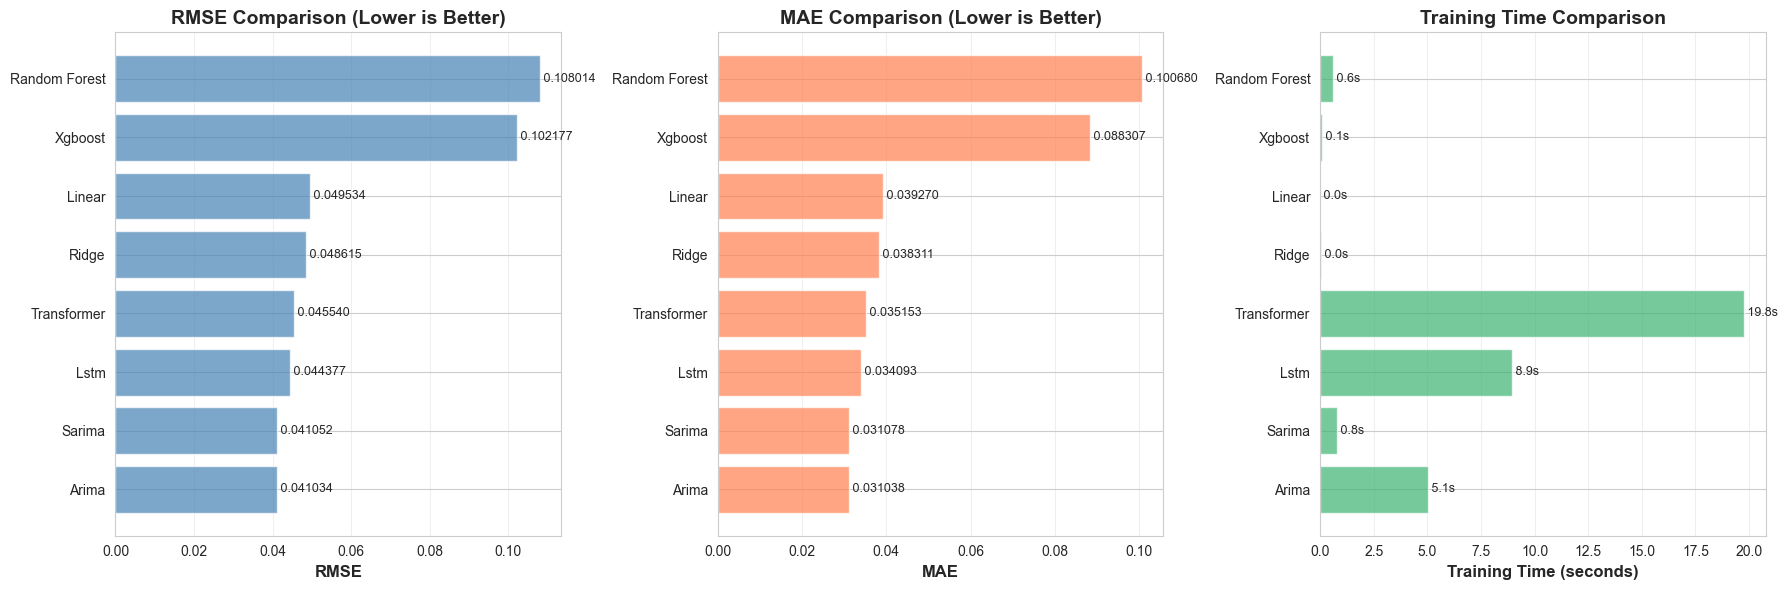


Best Model: Arima
   RMSE: 0.041034
   MAE: 0.031038


In [119]:
# Visualize model comparison
if len(results) > 0 and 'comparison_df' in locals():
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    models = comparison_df['Model'].values
    rmse_values = comparison_df['RMSE'].values
    mae_values = comparison_df['MAE'].values
    
    # RMSE comparison
    axes[0].barh(models, rmse_values, alpha=0.7, color='steelblue')
    axes[0].set_xlabel('RMSE', fontsize=12, fontweight='bold')
    axes[0].set_title('RMSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='x')
    for i, v in enumerate(rmse_values):
        axes[0].text(v, i, f' {v:.6f}', va='center', fontsize=9)
    
    # MAE comparison
    axes[1].barh(models, mae_values, alpha=0.7, color='coral')
    axes[1].set_xlabel('MAE', fontsize=12, fontweight='bold')
    axes[1].set_title('MAE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='x')
    for i, v in enumerate(mae_values):
        axes[1].text(v, i, f' {v:.6f}', va='center', fontsize=9)
    
    # Training time comparison (if available)
    time_values = []
    time_labels = []
    for model in models:
        model_key = model.lower().replace(' ', '_')
        if model_key in model_times:
            time_values.append(model_times[model_key])
            time_labels.append(f"{model_times[model_key]:.1f}s")
        else:
            time_values.append(0)
            time_labels.append("N/A")
    
    if any(time_values):
        axes[2].barh(models, time_values, alpha=0.7, color='mediumseagreen')
        axes[2].set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
        axes[2].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')
        for i, (v, label) in enumerate(zip(time_values, time_labels)):
            if v > 0:
                axes[2].text(v, i, f' {label}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Display best model
    best_model = comparison_df.iloc[0]
    print(f"\nBest Model: {best_model['Model']}")
    print(f"   RMSE: {best_model['RMSE']:.6f}")
    print(f"   MAE: {best_model['MAE']:.6f}")
else:
    print("Warning: Please run the model training cell first to generate visualizations.")
